Total images loaded: 1924
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.7510 - loss: 0.7061 - val_accuracy: 0.9903 - val_loss: 0.0363
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.9942 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 1.0000 - loss: 7.4652e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 1.0000 - loss: 4.2696e-04 - val_accuracy: 1.0000 - val_loss: 9.4409e-04
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 1.0000 - loss: 2.8644e-04 - val_accuracy: 1.0000 - val_loss: 7.6533e-04
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - acc

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 7.5565e-04
Test Loss: 0.0008476856746710837
Test Accuracy: 1.0


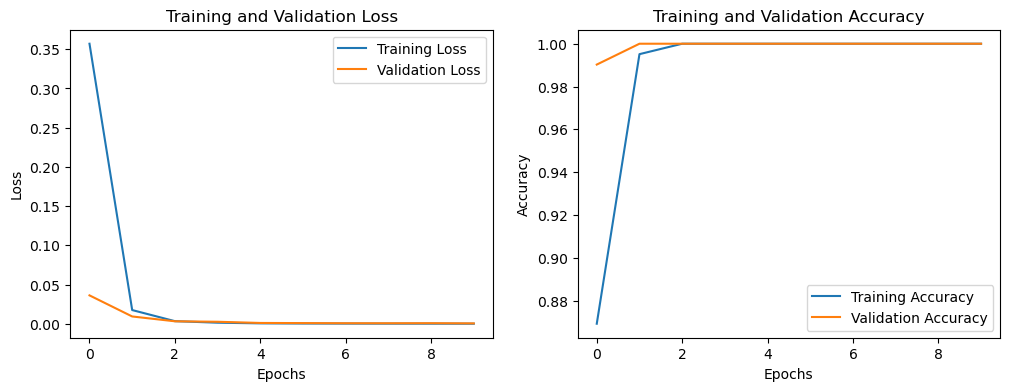

In [36]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Constants
image_dir = '/Users/sanvishukla/Desktop/pcos detection/data/images'  # Update this path if necessary
image_width = 128  # Adjust according to your image dimensions
image_height = 128
epochs = 10
batch_size = 32
validation_split = 0.2

# Function to load and preprocess image data
def load_and_preprocess_image(image_dir, image_width, image_height):
    X_images = []
    y_images = []
    
    infected_dir = os.path.join(image_dir, 'infected')
    notinfected_dir = os.path.join(image_dir, 'notinfected')
    
    if not os.path.isdir(infected_dir):
        print(f"Directory not found: {infected_dir}")
        return np.array(X_images), np.array(y_images)
    
    if not os.path.isdir(notinfected_dir):
        print(f"Directory not found: {notinfected_dir}")
        return np.array(X_images), np.array(y_images)
    
    # Load infected images
    for filename in os.listdir(infected_dir):
        img_path = os.path.join(infected_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (image_width, image_height))
            img = img.astype(np.float32) / 255.0  # Normalize image pixels to [0, 1]
            X_images.append(img)
            y_images.append(1.0)  # Label 1.0 for infected
        else:
            print(f"Failed to load image: {img_path}")
    
    # Load non-infected images
    for filename in os.listdir(notinfected_dir):
        img_path = os.path.join(notinfected_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (image_width, image_height))
            img = img.astype(np.float32) / 255.0  # Normalize image pixels to [0, 1]
            X_images.append(img)
            y_images.append(0.0)  # Label 0.0 for not infected
        else:
            print(f"Failed to load image: {img_path}")
    
    print(f"Total images loaded: {len(X_images)}")
    return np.array(X_images), np.array(y_images)

# Function to build the model
def build_model(input_shape_images):
    image_input = Input(shape=input_shape_images, name='image_input')

    # Image data branch
    image_branch = Conv2D(32, (3, 3), activation='relu')(image_input)
    image_branch = MaxPooling2D((2, 2))(image_branch)
    image_branch = Conv2D(64, (3, 3), activation='relu')(image_branch)
    image_branch = MaxPooling2D((2, 2))(image_branch)
    image_branch = Flatten()(image_branch)
    image_branch = Dense(64, activation='relu')(image_branch)

    output = Dense(1, activation='sigmoid')(image_branch)

    model = Model(inputs=image_input, outputs=output)
    
    return model

def train_model(model, X_images, y_images, epochs, batch_size, validation_split):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_images, y_images, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=validation_split,
                        callbacks=[early_stopping])
    
    # Save the trained model
    save_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model.save(os.path.join(save_path, 'pcos_detection_model.h5'))
    
    return model, history

# Main execution block for Jupyter Notebook
# Load and preprocess image data
X_images, y_images = load_and_preprocess_image(image_dir, image_width, image_height)

# Check if data is loaded properly
if len(X_images) == 0 or len(y_images) == 0:
    print("No images were loaded. Please check the image directories.")
else:
    # Split data into training and testing sets
    train_X_images, test_X_images, train_y_images, test_y_images = train_test_split(X_images, y_images, test_size=0.2, random_state=42)
    
    # Build the model
    model = build_model(train_X_images.shape[1:])
    
    # Train the model
    trained_model, history = train_model(model, train_X_images, train_y_images, epochs, batch_size, validation_split)
    
    # Evaluate the model
    test_loss, test_accuracy = trained_model.evaluate(test_X_images, test_y_images)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()


Total images loaded: 1924


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Confusion Matrix:
[[226   0]
 [  0 159]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       226
         1.0       1.00      1.00      1.00       159

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385



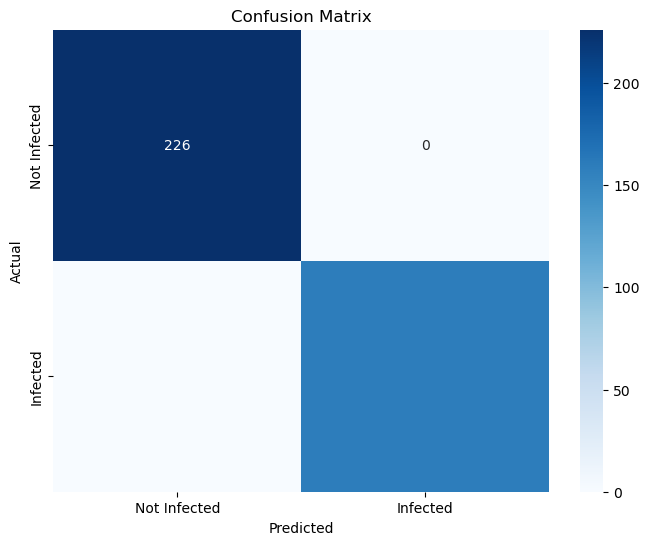

In [38]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
image_dir = '/Users/sanvishukla/Desktop/pcos detection/data/images'  # Update this path if necessary
image_width = 128
image_height = 128
model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/pcos_detection_model.h5'  # Path to the saved model


# Load and preprocess image data
X_images, y_images = load_and_preprocess_image(image_dir, image_width, image_height)

# Split data into training and testing sets
_, test_X_images, _, test_y_images = train_test_split(X_images, y_images, test_size=0.2, random_state=42)

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Predict on the test set
y_pred_prob = model.predict(test_X_images)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate metrics
accuracy = accuracy_score(test_y_images, y_pred)
precision = precision_score(test_y_images, y_pred)
recall = recall_score(test_y_images, y_pred)
f1 = f1_score(test_y_images, y_pred)
conf_matrix = confusion_matrix(test_y_images, y_pred)
class_report = classification_report(test_y_images, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Infected', 'Infected'], yticklabels=['Not Infected', 'Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [16]:
!pip install ipywidgets==7.6.3
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager@2.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 1.8 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.6.5
    Uninstalling ipywidgets-7.6.5:
      Successfully uninstalled ipywidgets-7.6.5
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu e

In [52]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to load and preprocess a single image
def load_and_preprocess_single_image(img_path, image_width, image_height):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (image_width, image_height))
    img = img.astype(np.float32) / 255.0  # Normalize image pixels to [0, 1]
    
    return img

# Function to predict PCOS using a single image
def predict_pcos(image_path, model):
    # Load and preprocess the image
    image_width = 128  # Adjust according to your model's input size
    image_height = 128
    img = load_and_preprocess_single_image(image_path, image_width, image_height)
    if img is None:
        return None
    
    # Reshape and expand dimensions to match model's input shape
    img = np.expand_dims(img, axis=0)
    
    # Perform prediction
    prediction = model.predict(img)
    
    # Interpret prediction
    if prediction[0][0] >= 0.5:
        return "Prediction: You are likely to have PCOS."
    else:
        return "Prediction: You are not likely to have PCOS."

# Path to the saved model
model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/pcos_detection_model.h5'

# Load the saved model
saved_model = load_model(model_path)

# Example usage: Predict PCOS for a new image
image_path_to_predict = '/Users/sanvishukla/Desktop/1.jpg'  # Replace with the path to your image
prediction_result = predict_pcos(image_path_to_predict, saved_model)

if prediction_result:
    print(f"Prediction Result: {prediction_result}")
else:
    print("Failed to make a prediction.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction Result: Prediction: You are likely to have PCOS.


In [54]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to load and preprocess a single image
def load_and_preprocess_single_image(img_path, image_width, image_height):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (image_width, image_height))
    img = img.astype(np.float32) / 255.0  # Normalize image pixels to [0, 1]
    
    return img

# Function to predict PCOS using a single image
def predict_pcos(image_path, model):
    # Load and preprocess the image
    image_width = 128  # Adjust according to your model's input size
    image_height = 128
    img = load_and_preprocess_single_image(image_path, image_width, image_height)
    if img is None:
        return None
    
    # Reshape and expand dimensions to match model's input shape
    img = np.expand_dims(img, axis=0)
    
    # Perform prediction
    prediction = model.predict(img)
    
    # Interpret prediction
    if prediction[0][0] >= 0.5:
        return "Prediction: You are likely to have PCOS."
    else:
        return "Prediction: You are not likely to have PCOS."

# Path to the saved model
model_path = '/Users/sanvishukla/Desktop/pcos detection/saved_models/pcos_detection_model.h5'

# Load the saved model
saved_model = load_model(model_path)

# Example usage: Predict PCOS for a new image
image_path_to_predict = '/Users/sanvishukla/Desktop/pcos detection/data/images/notinfected/img_0_4.jpg'  # Replace with the path to your image
prediction_result = predict_pcos(image_path_to_predict, saved_model)

if prediction_result:
    print(f"Prediction Result: {prediction_result}")
else:
    print("Failed to make a prediction.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction Result: Prediction: You are not likely to have PCOS.
